In [43]:
from pathlib import Path

import torch
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2Model
from tensorly.decomposition import parafac
import tensorly as tl
import tensortools as tt
#import nltk
#import spacy
from tensorly.cp_tensor import cp_normalize
import sys
sys.path.append('./model')
import dino # model

import object_discovery as tokencut
import argparse
import utils
import bilateral_solver
import os

from shutil import copyfile
import PIL.Image as Image
import cv2
import numpy as np
from tqdm import tqdm

from torchvision import transforms
import metric
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage
import torch
import torch.nn as nn
import seaborn as sns
import importlib
from sklearn.mixture import GaussianMixture as GMM


In [2]:
import torch
import torch.nn.functional as F
import numpy as np
from scipy.linalg import eigh
from scipy import ndimage

def ncut(feats, dims, scales, init_image_size, tau = 0, eps=1e-5, im_name='', no_binary_graph=False):
    """
    Implementation of NCut Method.
    Inputs
      feats: the pixel/patche features of an image
      dims: dimension of the map from which the features are used
      scales: from image to map scale
      init_image_size: size of the image
      tau: thresold for graph construction
      eps: graph edge weight
      im_name: image_name
      no_binary_graph: ablation study for using similarity score as graph edge weight
    """
    feats = F.normalize(feats, p=2, dim=0)
    #print(feats.shape)
    A = (feats.transpose(0,1) @ feats)
    A = A.detach().cpu().numpy()
    #tau = 0.01
    print(feats.shape, A.shape,tau) 
    if no_binary_graph:
        A[A<tau] = eps 
    else:
        A = A > tau
        A = np.where(A.astype(float) == 0, eps, A)
    
    d_i = np.sum(A, axis=1) #degree
    D = np.diag(d_i) #outgoing edges for each node

    # Print second and third smallest eigenvector
    _, eigenvectors = eigh(D-A, D, subset_by_index=[1,2])
    eigenvec = np.copy(eigenvectors[:, 0])
    print("eigenvec: ",eigenvec.shape)


    # method1 avg
    second_smallest_vec = eigenvectors[:, 0]
    avg = np.sum(second_smallest_vec) / len(second_smallest_vec)
    bipartition = second_smallest_vec > avg
    print('bipartition:', bipartition.shape)
    
    seed = np.argmax(np.abs(second_smallest_vec))

    if bipartition[seed] != 1:
        print('enter')
        eigenvec = eigenvec * -1
        bipartition = np.logical_not(bipartition)
    bipartition = bipartition.reshape(dims).astype(float)

    # predict BBox
    pred, _, objects,cc = detect_box(bipartition, seed, dims, scales=scales, initial_im_size=init_image_size) ## We only extract the principal object BBox

    #print('pred:', pred.shape)
    mask = np.zeros(dims)
    mask[cc[0],cc[1]] = 1

    mask = torch.from_numpy(mask).to('cuda')
#    mask = torch.from_numpy(bipartition).to('cuda')
    bipartition = F.interpolate(mask.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
    

    eigvec = second_smallest_vec.reshape(dims) 
    eigvec = torch.from_numpy(eigvec).to('cuda')
    eigvec = F.interpolate(eigvec.unsqueeze(0).unsqueeze(0), size=init_image_size, mode='nearest').squeeze()
    return  seed, bipartition.cpu().numpy(), eigvec.cpu().numpy()

def detect_box(bipartition, seed,  dims, initial_im_size=None, scales=None, principle_object=True):
    """
    Extract a box corresponding to the seed patch. Among connected components extract from the affinity matrix, select the one corresponding to the seed patch.
    """
    w_featmap, h_featmap = dims
    objects, num_objects = ndimage.label(bipartition)
    #print('object and num: ', objects, num_objects)
    cc = objects[np.unravel_index(seed, dims)]


    if principle_object:
        mask = np.where(objects == cc)
       # Add +1 because excluded max
        ymin, ymax = min(mask[0]), max(mask[0]) + 1
        xmin, xmax = min(mask[1]), max(mask[1]) + 1
        # Rescale to image size
        r_xmin, r_xmax = scales[1] * xmin, scales[1] * xmax
        r_ymin, r_ymax = scales[0] * ymin, scales[0] * ymax
        pred = [r_xmin, r_ymin, r_xmax, r_ymax]

        # Check not out of image size (used when padding)
        if initial_im_size:
            pred[2] = min(pred[2], initial_im_size[1])
            pred[3] = min(pred[3], initial_im_size[0])

        # Coordinate predictions for the feature space
        # Axis different then in image space
        pred_feats = [ymin, xmin, ymax, xmax]

        return pred, pred_feats, objects, mask
    else:
        raise NotImplementedError



In [17]:
url = "/dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth"
feat_dim = 384
vit_arch = 'small'
vit_feat = 'k'
patch_size = 16
dataset = 'ECSSD'
tau = 0.2
sigma_spatial = 16 
sigma_luma= 16 
sigma_chroma=8

In [4]:
vit_arch = 'base'
vit_feat = 'k'
patch_size = 8
# DINO pre-trained model
url = "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
url = "/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth"
feat_dim = 768
# MaskCut hyperparameters
fixed_size = 480

In [18]:
importlib.reload(dino)
backbone = dino.ViTFeat(url, feat_dim, vit_arch, vit_feat, patch_size)
msg = 'Load {} pre-trained feature...'.format(vit_arch)
print (msg)
backbone.eval()
backbone.cuda()

Loading weight from /dino/dino_deitsmall16_pretrain/dino_deitsmall16_pretrain.pth
Load small pre-trained feature...


ViTFeat(
  (model): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0-11): 12 x Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (drop_path): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
          (fc2): Linear(in_features=1536, out_features=384, bias=True)
          (drop): Dropout(p=0.0, inplace=False)
        )
      )
    )
    (norm): LayerNorm((

In [6]:
ToTensor = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Normalize((0.485, 0.456, 0.406),
                                                     (0.229, 0.224, 0.225)),])
def get_tokencut_binary_map(img_pth, backbone,patch_size, tau) :
    I = Image.open(img_pth).convert('RGB')
    I_resize, w, h, feat_w, feat_h = utils.resize_pil(I, patch_size)

    tensor = ToTensor(I_resize).unsqueeze(0).cuda()
    feat = backbone(tensor)[0]
    #feat = backbone.model.get_all_selfattention(tensor)
    #feat = torch.cat(feat,0)[-1,-1,1:,1:]
    #print(feat.shape)
    '''
    rank = 3
    attentions_tn = tl.tensor(feat)
    cp_factors = parafac(attentions_tn, rank=rank,mask = None, random_state = 42)
    cp_factors = cp_normalize(cp_factors)
    print(cp_factors.factors[0].shape,cp_factors.factors[1].shape)
    feat = np.einsum('a,b -> ab', cp_factors.factors[1][:,2], cp_factors.factors[2][:,2])
    feat = torch.tensor(feat)
    '''
    print('h',tensor.shape,len(feat),feat[0].shape)
    seed, bipartition, eigvec = ncut(feat, [feat_h, feat_w], [patch_size, patch_size], [h,w], tau)
    return bipartition, eigvec
    #seed, bipartition, eigvec = tokencut.ncut(feat, [feat_h, feat_w], [patch_size, patch_size], [h,w], tau)
    #return bipartition, eigvec, feat

In [7]:
img_dir = '/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/'

img_list = sorted(os.listdir(img_dir))

In [7]:
img_list

['.ipynb_checkpoints',
 '100480023.jpg',
 '101434689.jpg',
 '105805337.jpg',
 '106114666.jpg',
 '107068280.jpg',
 '107747623.jpg',
 '10776780.jpg',
 '108952811.jpg',
 '10922720.jpg',
 '109577302.jpg',
 '109865693.jpg',
 '110547945.jpg',
 '114059165.jpg',
 '114299883.jpg',
 '116421295.jpg',
 '11642343.jpg',
 '117799313.jpg',
 '118378507.jpg',
 '119908030.jpg',
 '121122122.jpg',
 '124334477.jpg',
 '124781945.jpg',
 '125088898.jpg',
 '125196156.jpg',
 '127481031.jpg',
 '127873079.jpg',
 '128656245.jpg',
 '130541569.jpg',
 '132480784.jpg',
 '132858229.jpg',
 '133738916.jpg',
 '134807737.jpg',
 '137029162.jpg',
 '13750464.jpg',
 '137590443.jpg',
 '137880835.jpg',
 '142670304.jpg',
 '142939031.jpg',
 '144516855.jpg',
 '145312282.jpg',
 '145322427.jpg',
 '146551239.jpg',
 '147057799.jpg',
 '147310995.jpg',
 '147520936.jpg',
 '14783686.jpg',
 '149212779.jpg',
 '149299948.jpg',
 '150911612.jpg',
 '152581000.jpg',
 '152802436.jpg',
 '153248650.jpg',
 '157141718.jpg',
 '157371067.jpg',
 '15773879

In [58]:
import Exp_Ncut_tensor_decomposition,metric_evaluation_batch,metric_evaluation_batch_rsquare,get_saliency

 40%|████      | 2/5 [00:00<00:00, 14.49it/s]

/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/145322427.jpg
h torch.Size([1, 3, 464, 368]) 384 torch.Size([667])
torch.Size([384, 667]) (667, 667) 0.05
eigenvec:  (667,)
bipartition: (667,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/146551239.jpg
h torch.Size([1, 3, 368, 304]) 384 torch.Size([437])
torch.Size([384, 437]) (437, 437) 0.05
eigenvec:  (437,)
bipartition: (437,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/147057799.jpg
h torch.Size([1, 3, 464, 336]) 384 torch.Size([609])
torch.Size([384, 609]) (609, 609) 0.05
eigenvec:  (609,)
bipartition: (609,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/147310995.jpg


 60%|██████    | 3/5 [00:00<00:00,  3.08it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.94 GiB (GPU 0; 23.68 GiB total capacity; 9.44 GiB already allocated; 11.65 GiB free; 9.74 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

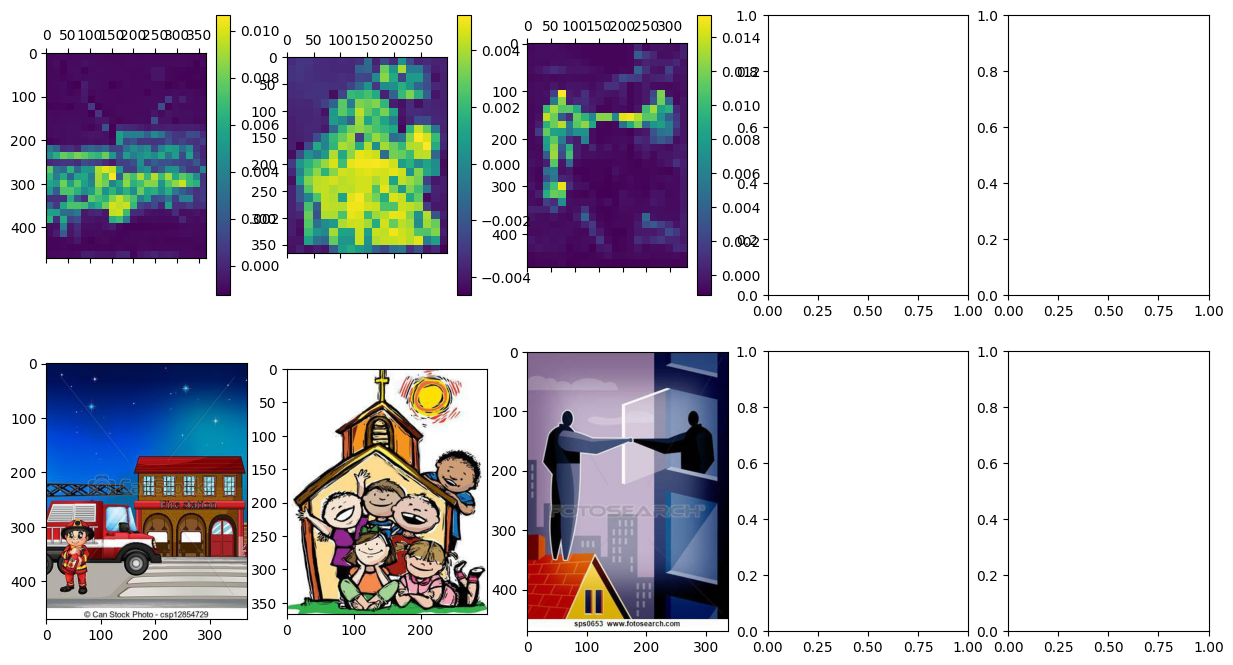

In [59]:
importlib.reload(metric_evaluation_batch_rsquare)
count_vis = 0
mask_lost = []
mask_bfs = []
gt = []

fig, ax = plt.subplots(2, 5, figsize=(15, 8))
i=0
for img_name in tqdm(img_list[41:46]) :
    
    img_pth = os.path.join(img_dir, img_name)
    print(img_pth)
    #img_pth = img_name
    bipartition, eigvec = get_tokencut_binary_map(img_pth, backbone, patch_size, tau=0.05)
    im = ax[0][i].matshow(eigvec, cmap='viridis')
    #cax2 = ax[i].matshow(bipartition, cmap='viridis')
    #ax[i].set_title(f'Token dimension {1} for Component {comp_idx+1}')
    image = plt.imread(img_pth)
    im2 = ax[1][i].imshow(image)
    fig.colorbar(im)
    i=i+1

fig.tight_layout()
plt.show()

In [66]:
import Exp_Ncut_tensor_decomposition,metric_evaluation_batch,get_saliency,metric_evaluation_batch_rsquare

In [10]:
img_pth='/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/106114666.jpg'

In [11]:
importlib.reload(Exp_Ncut_tensor_decomposition)
#feat,w, h, feat_w, feat_h = Exp_Ncut_tensor_decomposition.get_tokencut_binary_map(img_pth, backbone, patch_size, tau)

<module 'Exp_Ncut_tensor_decomposition' from '/vast/palmer/home.mccleary/cx95/TokenCut/unsupervised_saliency_detection/Exp_Ncut_tensor_decomposition.py'>

In [68]:
count= 0
mask_lost = []
mask_bfs =  {'rank_1':[], 'rank_2':[], 'rank_3': [],'rank_4': [],'rank_5': [],'rank_6': []}
gt = []
all_feat,all_w,all_h,all_feat_w,all_feat_h = [],[],[],[],[]
all_factors = []
eigvec_list = {'rank_1':[], 'rank_2':[], 'rank_3': [],'rank_4': [],'rank_5': [],'rank_6': []}
batch_feat =[]
mask_lost_1= {'rank_1':[], 'rank_2':[], 'rank_3': [],'rank_4': [],'rank_5': [],'rank_6': []}
batch_size = 1
combine_dim = 2
rank = 3
percentage = 0.5
img_path_list=[]
for img_name in tqdm(img_list[6:11]) :
    img_pth = os.path.join(img_dir, img_name)
    print(img_pth)
    img_path_list.append(img_pth)
    feat,w, h, feat_w, feat_h = metric_evaluation_batch_rsquare.get_tokencut_binary_map(img_pth, backbone, patch_size, tau)
    count+=1
    feat = torch.cat(feat,0)
    #(feat[:,:,-1,-1],feat.shape)
    feat = feat[-3:,:,1:,1:]
    print(len(feat),feat.shape)
    #all_feat.append(torch.cat(feat,0))
    all_feat.append(feat)
    all_w.append(w)
    all_h.append(h)
    all_feat_w.append(feat_w)
    all_feat_h.append(feat_h)
    batch_feat.append(feat)
    if (count)%batch_size ==0:
            #feat, masks, token_sizes = Exp_Ncut_tensor_decomposition.pad_tensors_and_create_masks(batch_feat, dim = combine_dim)
            #if feat == None:
            #    feat = torch.cat(batch_feat,combine_dim)
            #print('after padding:',feat.shape)
            batch_feat = []
            
            X = feat.detach().cpu().numpy()
            attentions_tn = tl.tensor(X)
            #print('masks: ',type(attentions_tn),type(masks))
            cp_factors = parafac(attentions_tn, rank=rank,mask = masks, random_state = 42)
            cp_factors = cp_normalize(cp_factors)
    
            max_size = int(cp_factors.factors[combine_dim].shape[0]/batch_size)
            print("max size", max_size,cp_factors.factors[combine_dim].shape[0],batch_size)
            factor = metric_evaluation_batch_rsquare.divide_tensor(cp_factors,max_size,batch_size,token_sizes,combine_dim)
            all_factors.append(cp_factors)
            for sample in range(batch_size):
                for i in range(rank):
                    token_comp1 = factor[sample][:,i]
                    diff = batch_size - sample
                    print(all_feat_h,all_feat_w,count-diff,token_comp1.shape)
    
                    _, bipartition,eigvec = metric_evaluation_batch_rsquare.ncut(token_comp1,  [all_feat_h[count-diff], all_feat_w[count-diff]], [patch_size, patch_size], [all_h[count-diff],all_w[count-diff]],'normalized',percentage,tau)
                    name = 'rank_'+ str(i+1)
                    
                    mask_lost_1[name].append(bipartition)
                    eigvec_list[name].append(eigvec)

            img_path_list = []
   
    mask_lost.append(feat)

  0%|          | 0/5 [00:00<?, ?it/s]

/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/107747623.jpg
3 torch.Size([3, 6, 242, 242])


 20%|██        | 1/5 [00:00<00:02,  1.55it/s]

max size 242 242 1
[22] [11] 0 (242,)
[22] [11] 0 (242,)
[22] [11] 0 (242,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/10776780.jpg
3 torch.Size([3, 6, 560, 560])


 60%|██████    | 3/5 [00:06<00:04,  2.07s/it]

max size 560 560 1
[22, 20] [11, 28] 1 (560,)
[22, 20] [11, 28] 1 (560,)
[22, 20] [11, 28] 1 (560,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/108952811.jpg
3 torch.Size([3, 6, 88, 88])
max size 88 88 1
[22, 20, 8] [11, 28, 11] 2 (88,)
[22, 20, 8] [11, 28, 11] 2 (88,)
[22, 20, 8] [11, 28, 11] 2 (88,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/10922720.jpg
3 torch.Size([3, 6, 100, 100])


 80%|████████  | 4/5 [00:06<00:01,  1.33s/it]

max size 100 100 1
[22, 20, 8, 10] [11, 28, 11, 10] 3 (100,)
[22, 20, 8, 10] [11, 28, 11, 10] 3 (100,)
[22, 20, 8, 10] [11, 28, 11, 10] 3 (100,)
/vast/palmer/home.mccleary/cx95/palmer_scratch/tokencut/Clipart/clipart/JPEGImages/109577302.jpg
3 torch.Size([3, 6, 672, 672])


100%|██████████| 5/5 [00:12<00:00,  2.55s/it]

max size 672 672 1
[22, 20, 8, 10, 24] [11, 28, 11, 10, 28] 4 (672,)
[22, 20, 8, 10, 24] [11, 28, 11, 10, 28] 4 (672,)
[22, 20, 8, 10, 24] [11, 28, 11, 10, 28] 4 (672,)


100%|██████████| 5/5 [00:00<00:00, 20.53it/s]

(350, 176)
(320, 450)
(120, 170)
(168, 168)
(385, 450)


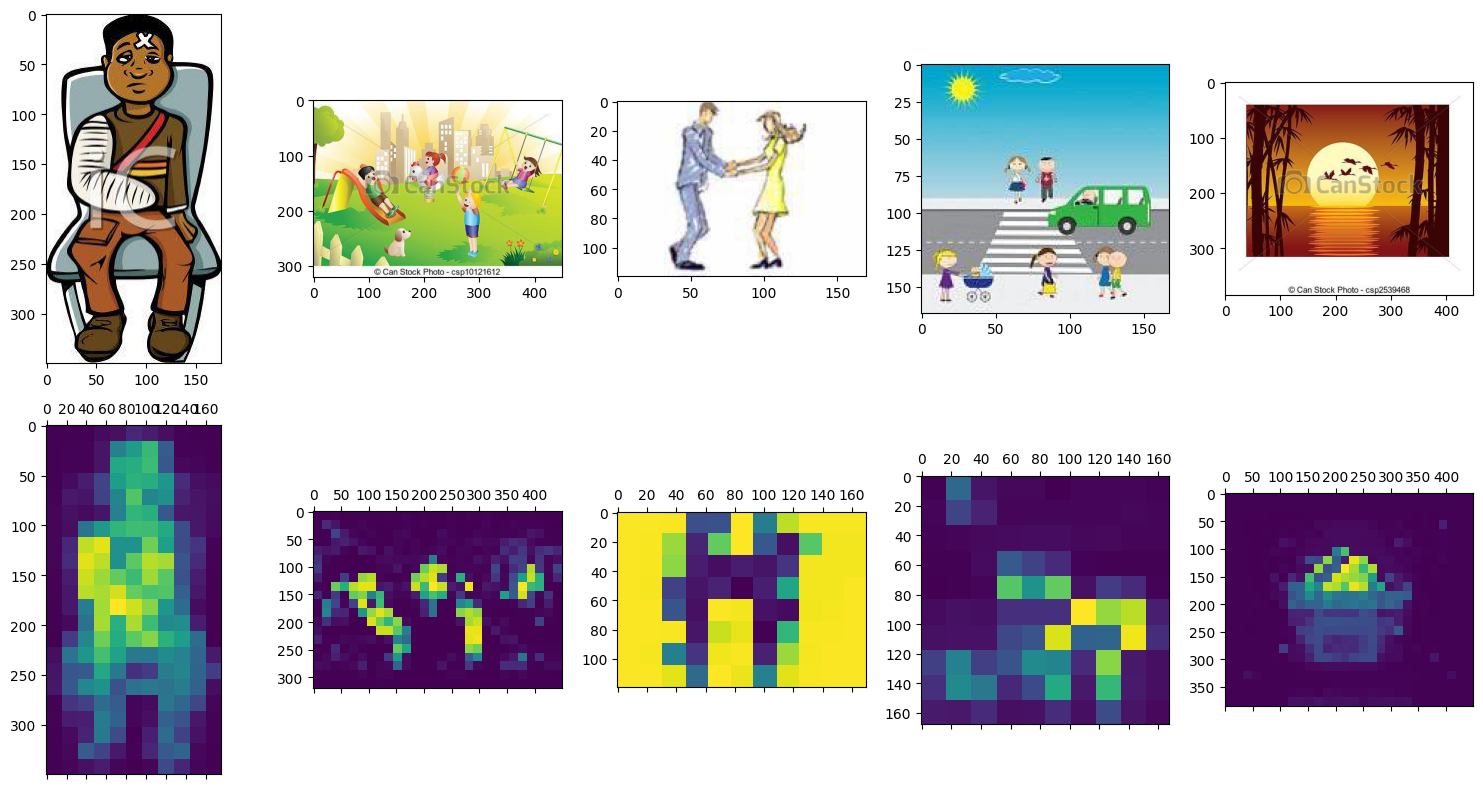

In [64]:
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
i=0
factors= []
all_feat_h,all_feat_w = [],[]
all_feat = []
for img_name in tqdm(img_list[6:11]) :
    
    img_pth = os.path.join(img_dir, img_name)
    image = plt.imread(img_pth)
    im2 = ax[0][i].imshow(image)
    fig.colorbar(im)
    feat,eigvec = get_saliency.get_tokencut_binary_map(img_pth, backbone, patch_size, tau=0.2)
    
    all_feat.append(feat)
    #feat = F.normalize(feat, p=2, dim=-2)
    
    
    #attentions_tn = tl.tensor(X)
    #cp_factors = parafac(attentions_tn, rank=5, random_state = 42)
    #cp_factors = cp_normalize(cp_factors)
    #factors.append(cp_factors)
    #eigvec = cp_factors.factors[1][:,2].reshape([feat_h,feat_w])
    print(eigvec.shape)
    im3 = ax[1][i].matshow(eigvec, cmap='viridis')
    
    
    i=i+1
    
fig.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots(3, 5, figsize=(15, 6))
i=0
print(all_factors[i])
for img_name in tqdm(img_list[6:11]) :
    
    img_pth = os.path.join(img_dir, img_name)
    image = plt.imread(img_pth)
    im2 = ax[0][i].imshow(image)
    fig.colorbar(im)
    #eigvec = factors[i].factors[1][:,1].reshape([all_feat_h[i],all_feat_w[i]])
    eigvec = all_factors[i].factors[2][:,0].reshape([all_feat_h[i],all_feat_w[i]])
    bipartition = GMM(n_components=2).fit_predict(eigvec.reshape(-1,1)).reshape(eigvec.shape)
    im3 = ax[1][i].matshow(eigvec, cmap='viridis')
    im3 = ax[2][i].matshow(bipartition, cmap='viridis')


    i=i+1

fig.tight_layout()
plt.show()

(weights, factors) : rank-3 CPTensor of shape (3, 6, 242, 242)


100%|██████████| 5/5 [00:00<00:00, 40.37it/s]


In [62]:
feat[0,0,:,:]

IndexError: too many indices for tensor of dimension 3

In [95]:
feat = F.normalize(feat, p=2, dim=-1)

In [110]:
feat= feat>np.average(feat.detach().cpu().numpy())

In [125]:
X = feat.detach().cpu().numpy()
attentions_tn = tl.tensor(X)
cp_factors = parafac(attentions_tn, rank=5, random_state = 42)
cp_factors = cp_normalize(cp_factors)

(22, 28)


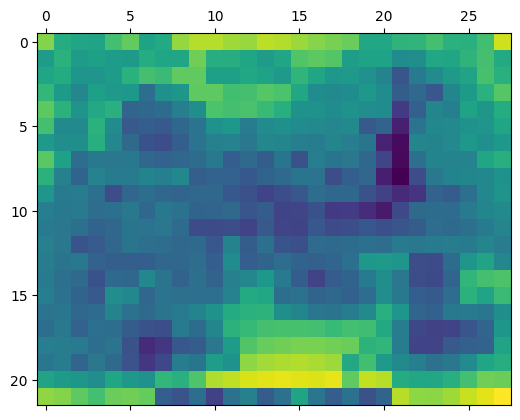

In [133]:
eigvec = cp_factors.factors[2][:,2].reshape([feat_h,feat_w])
print(eigvec.shape)
plt.matshow(eigvec, cmap='viridis')

In [12]:
import tensorly as tl
from tensorly.decomposition import parafac, tucker

# Assume 'tensor_4d' is your 4D tensor
tensor_4d = np.random.rand(6,6,12,12)
# CP Decomposition
factors = parafac(tensor_4d, rank=5)  # Adjust 'rank' as needed

# Tucker Decomposition
core, factors = tucker(tensor_4d, rank=[1, 1, 5, 5])  # Adjust 'ranks' as needed

# Compressing to 2D - example using one factor matrix
compressed_2d = factors[2]  # This is just an example

In [13]:
core.shape,compressed_2d.shape

((1, 1, 5, 5), (12, 5))

In [14]:
a = compressed_2d@core.squeeze()@(factors[3].transpose(1,0))

100%|██████████| 1/1 [00:15<00:00, 15.13s/it]

(20, 546)


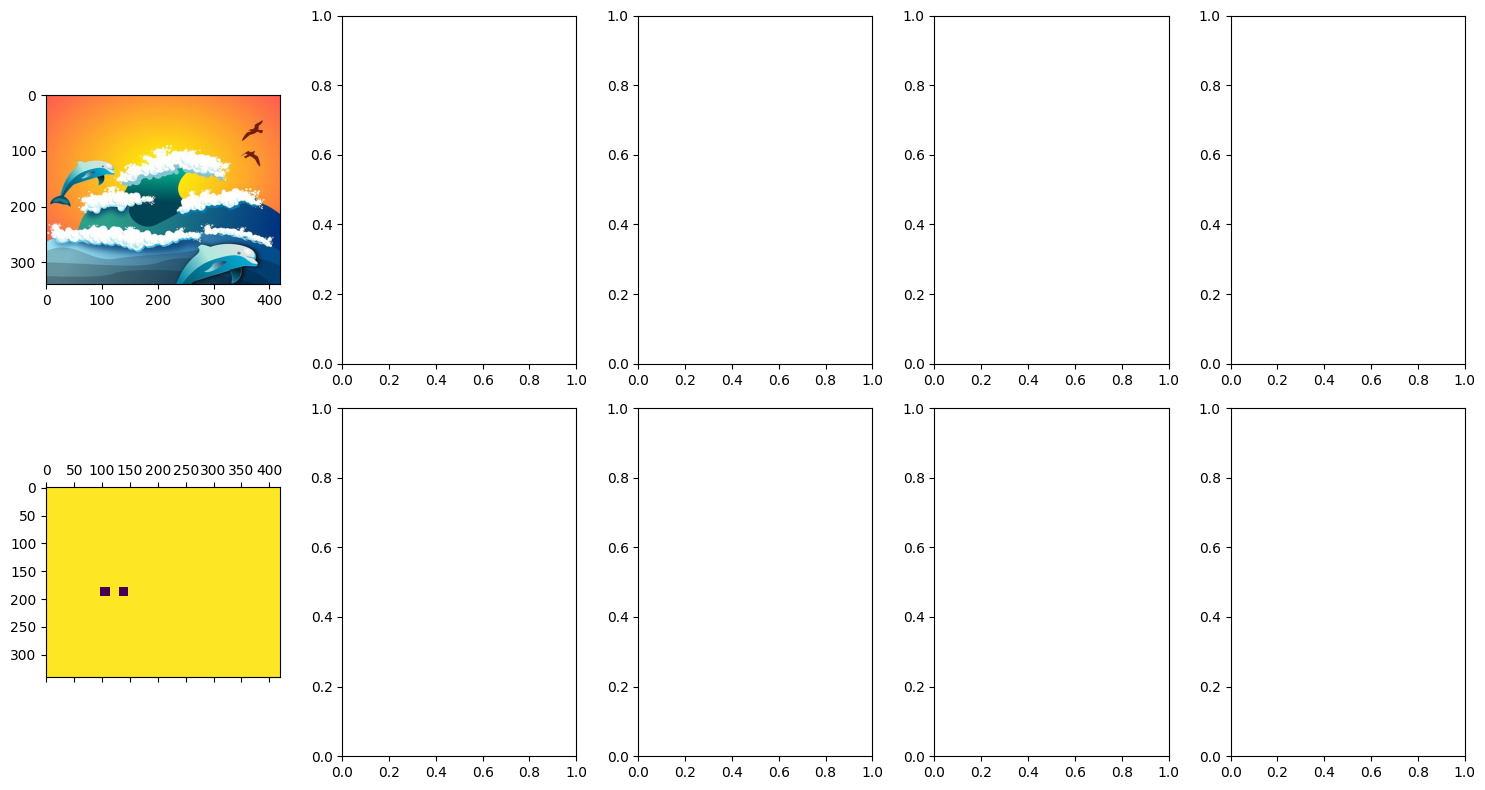

In [20]:
importlib.reload(Exp_Ncut_tensor_decomposition)
fig, ax = plt.subplots(2, 5, figsize=(15, 8))
i=0
factors= []
all_feat_h,all_feat_w = [],[]
for img_name in tqdm(img_list[16:17]) :
    
    img_pth = os.path.join(img_dir, img_name)
    image = plt.imread(img_pth)
    im2 = ax[0][i].imshow(image)
    fig.colorbar(im)
    feat,w, h, feat_w, feat_h = Exp_Ncut_tensor_decomposition.get_tokencut_binary_map(img_pth, backbone, patch_size, tau)
    all_feat_h.append(feat_h)
    all_feat_w.append(feat_w)
    feat = torch.cat(feat,0)
    feat = feat[:,:,1:,1:].detach().cpu().numpy()
    core, factors = tucker(feat, rank=[1, 1, 20,20])
    a = factors[2].transpose(1,0)#@core.squeeze()@(factors[3].transpose(1,0))
    print(a.shape)
    #_,bipartition,eigvec = Exp_Ncut_tensor_decomposition.ncut(torch.tensor(a), [feat_h, feat_w], [patch_size, patch_size], [h,w],tau = tau)
    im3 = ax[1][i].matshow(eigvec, cmap='viridis')


    i=i+1

fig.tight_layout()
plt.show()

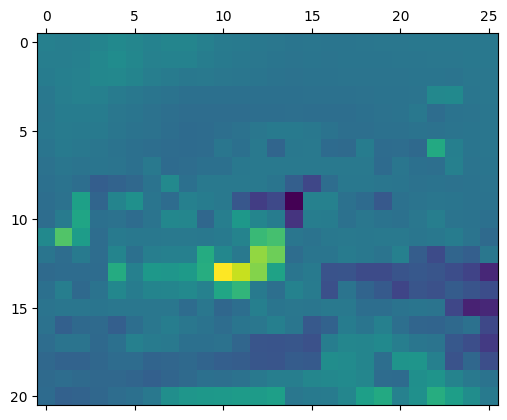

In [35]:

eigvec[eigvec==np.max(eigvec)]=np.average(eigvec)
plt.matshow(factors[2][:,11].reshape([feat_h, feat_w]), cmap='viridis')